## Insight Smiles' NA values
Importo la tabella con tutti i cas number e gli smiles, e mi creo un dataset con solo i CAS number

In [3]:
import pandas as pd

cas_smiles = pd.read_csv('dataset/cas_to_smiles.csv').drop(columns = 'Unnamed: 0')

cas = cas_smiles.cas

cas.to_csv('dataset/only_cas.csv', header = 'cas')

Vado su R, per vedere se si può evitare di far venire NA tramite il pacchetto webchem.

Dopo un'attenta analisi non si possono evitare gli NA. Quei composti che presentano NA, non hanno una rappresentazione SMILES. Inoltre, non vengono trovati neanche in Chemspider. 

Non saprei come muovermi...

Contiamo il numero di NA:

In [3]:
number_smiles = cas_smiles.shape[0]
number_smiles_na =len(cas_smiles[cas_smiles['smiles'].isna()])
print('Il numero di CAS number non tradotti in SMILES sono {}, a fronte dei {} totali'.format(number_smiles_na,
                                                                                              number_smiles))

Il numero di CAS number non tradotti in SMILES sono 465, a fronte dei 3201 totali


Importo il dataset finale preprocessato da Marco & co. La variabile target è **conc1_mean**.

In [4]:
final_db_prep = pd.read_csv('dataset/final_db_processed.csv')
use_db = final_db_prep.copy()
print(final_db_prep.shape)
print(final_db_prep.columns)

(23332, 19)
Index(['test_cas', 'species', 'conc1_type', 'exposure_type',
       'obs_duration_mean', 'conc1_mean', 'atom_number', 'alone_atom_number',
       'bonds_number', 'doubleBond', 'tripleBond', 'ring_number', 'Mol',
       'MorganDensity', 'LogP', 'class', 'tax_order', 'family', 'genus'],
      dtype='object')


Voglio plottare la variabile target:

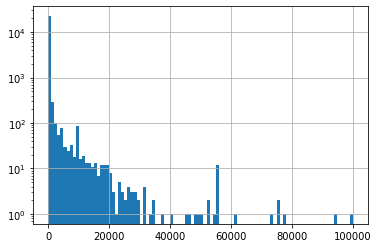

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# mettere scala log anche su conc1_mean, aggiungere mediana

use_db['conc1_mean'].hist(bins = 100, log = True)

# plt.hist(use_db['conc1_mean'])
# plt.show()

In [7]:
# concentrazioni inferiori e superiori a 1
conc_inf1 = len(use_db[use_db['conc1_mean'] <=1]) 
conc_sup1 = len(use_db[use_db['conc1_mean'] >1])
print('''I test che hanno una concentrazione media inferiore o uguale a 1 sono {}
mentre quelli superiore a 1 sono {}'''.format(conc_inf1,conc_sup1))


I test che hanno una concentrazione media inferiore o uguale a 1 sono 8566
mentre quelli superiore a 1 sono 14766


In [9]:
# concetrazione 
import numpy as np
np.median(use_db['conc1_mean'])

3.6

Divido il dataset nei test che hanno concentrazione superiore e inferiore a 1

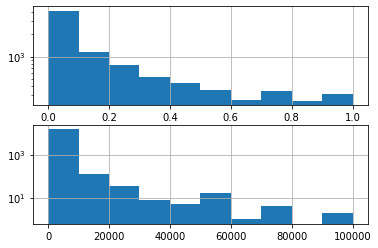

In [11]:
use_db_inf1 = use_db[use_db.conc1_mean <=1]
use_db_sup1 = use_db[use_db.conc1_mean > 1]

plt.subplot(2,1,1)
# scala log anche sotto
use_db_inf1.conc1_mean.hist(log = True)
plt.subplot(2,1,2)
# scala log anche sotto
use_db_sup1.conc1_mean.hist(log = True)

# # si aspetta più piatto

Facciamo un istogramma dividendo in due gruppi lungo il valore della soglia 1. Esce male.

Dividiamo in 5 soglie il dataset: $10^i$ con $i=-1,0,1,2,+\infty$

[4188, 4378, 5948, 5472, 3346]


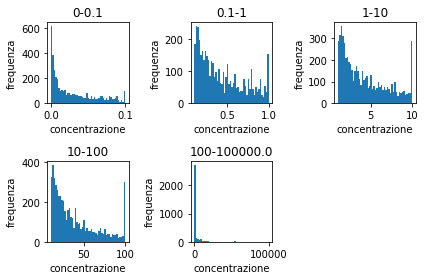

In [39]:
soglie = [0, 0.1, 1,10,100, max(use_db.conc1_mean)]
quant = list()
# mettere scala log --> bin logaritmici
for i in range(0,len(soglie)-1):
    # genero i grafici
    plt.subplot(2,3,i+1)
    plt.hist(use_db[(use_db.conc1_mean > soglie[i]) & (use_db.conc1_mean <= soglie[i+1])]['conc1_mean'], bins=50)
    plt.title('{}-{}'.format(soglie[i],soglie[i+1]))
    plt.xlabel('concentrazione')
    plt.ylabel('frequenza')
    # tengo traccia del numero di unità all'interno di ciascuna soglia
    quant.append(len(use_db[(use_db.conc1_mean > soglie[i]) & (use_db.conc1_mean <= soglie[i+1])]))
    
print(quant)
plt.tight_layout()
plt.show()

# Dividere le feature per animale e agente chimico

In [42]:

feat_chem = use_db[['test_cas', 'conc1_type','exposure_type',
       'obs_duration_mean', 'conc1_mean', 'atom_number', 'alone_atom_number',
       'bonds_number', 'doubleBond', 'tripleBond', 'ring_number', 'Mol',
       'MorganDensity', 'LogP']]
feat_chem.head()

,test_cas,conc1_type,exposure_type,obs_duration_mean,conc1_mean,atom_number,alone_atom_number,bonds_number,doubleBond,tripleBond,ring_number,Mol,MorganDensity,LogP
0,100-00-5,F,F,48.0,15.0,0.317908,2,0.488106,1,0,1.0,0.535725,1.300,2.2482
1,100-00-5,F,F,96.0,15.0,0.317908,2,0.488106,1,0,1.0,0.535725,1.300,2.2482
2,100-01-6,F,S,96.0,87.6,0.317908,2,0.488106,1,0,1.0,0.510371,1.300,1.1770
3,100-02-7,F,AQUA,48.0,26.5,0.317908,2,0.488106,1,0,1.0,0.511738,1.300,1.3004
4,100-44-7,F,S,96.0,4.0,0.217006,0,0.447258,0,0,1.0,0.493578,1.125,2.4254


In [47]:
feat_anim = use_db[['species','class', 'tax_order', 'family', 'genus']]
feat_anim.head()

,species,class,tax_order,family,genus
0,rerio,Actinopterygii,Cypriniformes,Cyprinidae,Danio
1,rerio,Actinopterygii,Cypriniformes,Cyprinidae,Danio
2,rerio,Actinopterygii,Cypriniformes,Cyprinidae,Danio
3,rerio,Actinopterygii,Cypriniformes,Cyprinidae,Danio
4,rerio,Actinopterygii,Cypriniformes,Cyprinidae,Danio


# Analisi di species

In [56]:
species = pd.read_csv('dataset/raw/species.txt', sep = '\|', engine = 'python')
print(species.columns)

Index(['species_number', 'common_name', 'latin_name', 'kingdom',
       'phylum_division', 'subphylum_div', 'superclass', 'class', 'tax_order',
       'family', 'genus', 'species', 'subspecies', 'variety', 'ecotox_group'],
      dtype='object')


In [66]:
def null_output_counts(feature, dataframe):
    
    # Find columns that start with the interesting feature
    cols = list(dataframe.columns)
    features_interested = [i for i in cols if i.startswith(feature)]
    df_nan  = pd.DataFrame (index = features_interested, columns = ['null_values_inc_NC_NR%', '#outputs'])
    
    #Count total NaN + NR + NC
    for i in features_interested:
        df_nan['null_values_inc_NC_NR%'][i] = (sum(dataframe[i].isnull()) + len(dataframe[dataframe[i] == "NR"]) + len(dataframe[dataframe[i] =="NC"]))/len(dataframe)*100
        df_nan['#outputs'][i] = len(dataframe[i].unique())
    return df_nan, features_interested

In [112]:
db_util,feat = null_output_counts('species_number', species)
for f in species.columns[1:]:
    temp, feat = null_output_counts(f, species)
    db_util = pd.concat([db_util,temp], axis = 0)

db_util.sort_values('null_values_inc_NC_NR%')
# db_util


,null_values_inc_NC_NR%,#outputs
species_number,0,26321
latin_name,0,26301
species_number,0,26321
kingdom,0.00379925,8
ecotox_group,0.0341932,59
phylum_division,0.0835835,79
common_name,0.664868,13617
class,1.61088,211
tax_order,1.89962,1050
family,5.94582,2341


Le variabili: **variety**, **subspecies**, **superclass** e **subphylum_div** sono inutilizzabili perchè hanno la quasi totalità di valori mancanti.

La variabile: **common_name**, **species_number**, **common_name** e **latin_name** sono intulizzabili perchè hanno troppi valori di output.

In [113]:
# filtro le variabili che hanno meno del 50% di risposte mancanti
db_util = db_util[db_util['null_values_inc_NC_NR%']< 50]
# filtro le variabili che hanno meno di 10000 modalità
db_util = db_util[db_util['#outputs']< 10000]
# riordino
db_util.sort_values('null_values_inc_NC_NR%')

,null_values_inc_NC_NR%,#outputs
kingdom,0.00379925,8
ecotox_group,0.0341932,59
phylum_division,0.0835835,79
class,1.61088,211
tax_order,1.89962,1050
family,5.94582,2341
genus,13.7685,7740
species,13.8483,9429


Io terrei queste variabili qua sopra, per ora. **phylum_div** può essere utile? Che significato ha?

In [117]:
# colonne da tenere
col_util = db_util.index
col_util

Index(['kingdom', 'phylum_division', 'class', 'tax_order', 'family', 'genus',
       'species', 'ecotox_group'],
      dtype='object')

In [124]:
# costruisco dataset con quelle variabili devo fare preprocessing...
sp_free = species[col_util]
sp_free.head()

,kingdom,phylum_division,class,tax_order,family,genus,species,ecotox_group
0,Animalia,Chordata,Actinopterygii,Cypriniformes,Cyprinidae,Pimephales,promelas,"Fish,Standard Test Species"
1,Animalia,Chordata,Actinopterygii,Perciformes,Centrarchidae,Lepomis,macrochirus,"Fish,Standard Test Species"
2,Animalia,Chordata,Actinopterygii,Salmoniformes,Salmonidae,Salvelinus,fontinalis,"Fish,Standard Test Species"
3,Animalia,Chordata,Actinopterygii,Salmoniformes,Salmonidae,Oncorhynchus,mykiss,"Fish,Standard Test Species,U.S. Exotic/Nuisanc..."
4,Animalia,Arthropoda,Branchiopoda,Diplostraca,Daphniidae,Daphnia,magna,"Crustaceans,Standard Test Species"


In [125]:
# salvo in un file pkl, questo dataset
sp_free.to_pickle('species_free.pkl')

# Analisi features

In [152]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
sp_free = pd.read_pickle('species_free.pkl')
sp_free.head()

,kingdom,phylum_division,class,tax_order,family,genus,species,ecotox_group
0,Animalia,Chordata,Actinopterygii,Cypriniformes,Cyprinidae,Pimephales,promelas,"Fish,Standard Test Species"
1,Animalia,Chordata,Actinopterygii,Perciformes,Centrarchidae,Lepomis,macrochirus,"Fish,Standard Test Species"
2,Animalia,Chordata,Actinopterygii,Salmoniformes,Salmonidae,Salvelinus,fontinalis,"Fish,Standard Test Species"
3,Animalia,Chordata,Actinopterygii,Salmoniformes,Salmonidae,Oncorhynchus,mykiss,"Fish,Standard Test Species,U.S. Exotic/Nuisanc..."
4,Animalia,Arthropoda,Branchiopoda,Diplostraca,Daphniidae,Daphnia,magna,"Crustaceans,Standard Test Species"


## Kingdom

In [146]:
kingdom = sp_free.kingdom
print('I valori mancanti sono {}'.format( sum( kingdom.isnull() + sum(kingdom == 'NR') + sum(kingdom == 'NC') ) ) )

I valori mancanti sono 1


In [165]:
# Calcolo frequenze
kingdom.value_counts(dropna =False)

Animalia     15658
Plantae       7502
Fungi         1934
Chromista      957
Monera         256
Protista         8
Community        5
NaN              1
Name: kingdom, dtype: int64

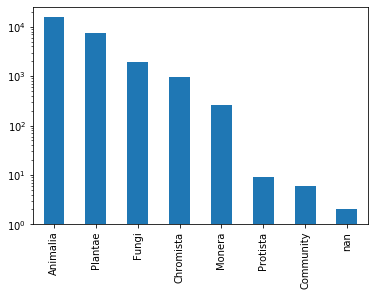

In [176]:
kingdom.value_counts(dropna =False).plot.bar(log = True)

Si potrebbe aggregare tutti e tre (*Protista*, *Community* e nan) in un un'unica modalità definita **"altro"**.

## phylum_division

In [168]:
ph_div = sp_free.phylum_division
print('I valori mancanti sono {}'.format( sum( ph_div.isnull() + sum(ph_div == 'NR') + sum(ph_div == 'NC') ) ) )

I valori mancanti sono 22


In [169]:
# Calcolo frequenze
ph_div.value_counts(dropna =False)

Arthropoda       8080
Magnoliophyta    5958
Chordata         3889
Ascomycota       1275
Mollusca         1177
                 ... 
Rhombozoa           2
Cryptophyta         2
Onychophora         1
Nemata              1
Phoronida           1
Name: phylum_division, Length: 79, dtype: int64

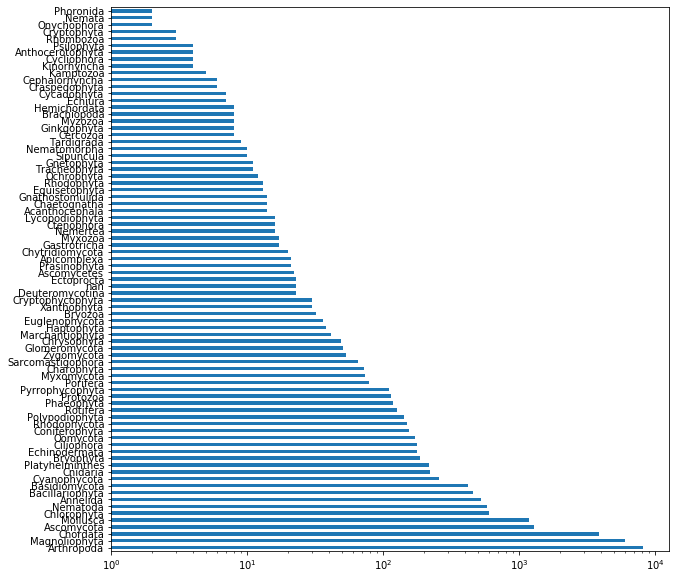

In [175]:
plt.figure(figsize=(10,10))
ph_div.value_counts(dropna =False).plot(kind='barh', log= True)
plt.show()

# class

In [183]:
cl = sp_free['class']
print('I valori mancanti sono {}'.format( sum( cl.isnull() + sum(cl == 'NR') + sum(cl == 'NC') ) ) )

I valori mancanti sono 424


In [185]:
# nuimero di modalità
len(cl.unique())

211

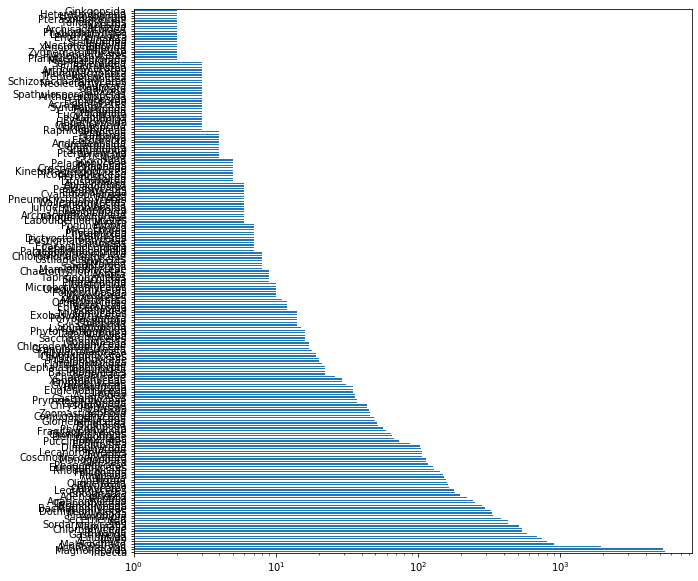

In [186]:
plt.figure(figsize=(10,10))
cl.value_counts(dropna =False).plot(kind='barh', log= True)
plt.show()

# tax_order

In [189]:
taxo = sp_free['tax_order']
print('I valori mancanti sono {}'.format( sum( taxo.isnull() + sum(taxo == 'NR') + sum(taxo == 'NC') ) ) )

I valori mancanti sono 500


In [188]:
# numero di modalità
len(taxo.unique())
# non plotto perchè sono veramente troppe ... forse non è da considerare

1050

# family

In [190]:
fam = sp_free['family']
print('I valori mancanti sono {}'.format( sum( fam.isnull() + sum(fam == 'NR') + sum(fam == 'NC') ) ) )

I valori mancanti sono 1565


In [191]:
# numero di modalità
len(fam.unique())

2341

# genus

In [192]:
gen = sp_free['genus']
print('I valori mancanti sono {}'.format( sum( gen.isnull() + sum(gen == 'NR') + sum(gen == 'NC') ) ) )

I valori mancanti sono 3624


In [193]:
# numero di modalità
len(gen.unique())

7740

# species

In [194]:
sp = sp_free['species']
print('I valori mancanti sono {}'.format( sum( taxo.isnull() + sum(taxo == 'NR') + sum(taxo == 'NC') ) ) )

I valori mancanti sono 500


In [195]:
# numero di modalità
len(taxo.unique())

1050

# ecotox_group

In [196]:
ecox = sp_free['ecotox_group']
print('I valori mancanti sono {}'.format( sum( ecox.isnull() + sum(ecox == 'NR') + sum(ecox == 'NC') ) ) )

I valori mancanti sono 9


In [197]:
# numero di modalità
len(ecox.unique())

59

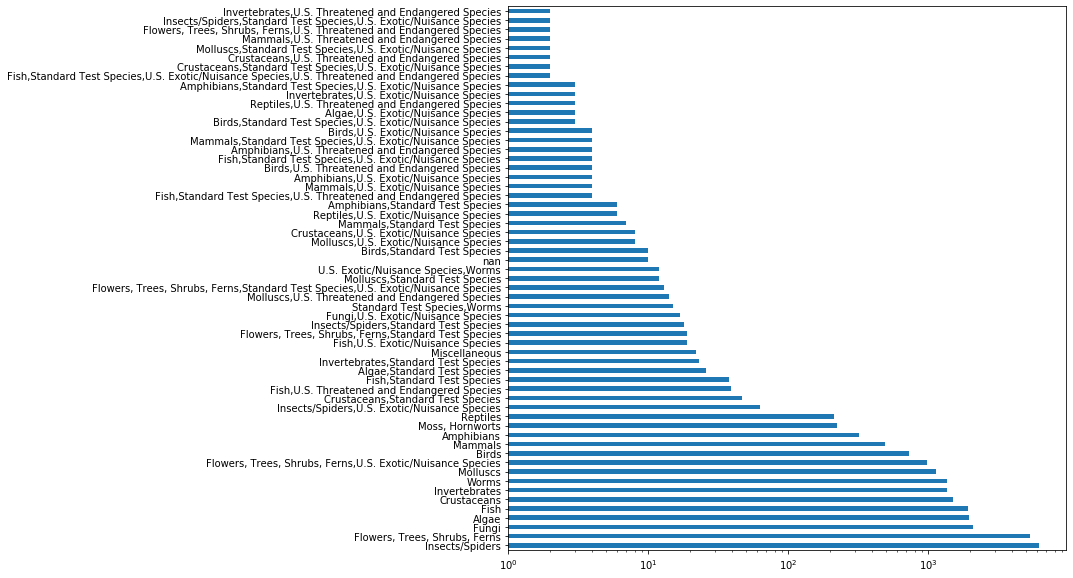

In [199]:
plt.figure(figsize=(10,10))
ecox.value_counts(dropna =False).plot(kind='barh', log= True)

ecotox_group si potrebbe unificare e ridurre il numero di modalità... riunire ad esempio tutti i mammals/fish/birds...